<a href="https://colab.research.google.com/github/deClot/Hakaton_Superhero/blob/master/3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from plotly.offline import init_notebook_mode, iplot

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

import IPython

def display(*dfs):
    for df in dfs:
        IPython.display.display(df)
 
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)


plt.rcParams['figure.figsize'] = [10,5]

In [296]:
def get_season(x):
  return 1 if x in [12,1,2] else 2 if x in [3,4,5] else 3 if x in [6,7,8] else 4

def preprocess_datetime(df, time_columns):
    for t in time_columns:
        df[t+'_month'] = df[t].dt.month
        df[t+'_season'] = df[t+'_month'].apply(get_season)
        df[t+'_is_month_start'] = df[t].dt.is_month_start
        df[t+'_is_month_end'] = df[t].dt.is_month_end
        df[t+'_day'] = df[t].dt.day
        # df[t+'_hour'] = df[t].dt.hour
        df[t+'_dayofweek'] = df[t].dt.dayofweek
        df[t+'_is_weekend'] = df[t+'_dayofweek'] >= 5
        df[t+'_quarter'] = df[t].dt.quarter

def get_regions(df):
  base = {'Кукморский': 'Кукмор',
          'Мамадышский': 'Мамадыш',
          'Нурлатский': 'Нурлат',
          'Азнакаевский': 'Азнакаево', 
          'Апастовский':'Апастово',
          'Бугульминский': 'Бигульма',
          'Елабужский':'Елабуга',
          'Бавлинский':'Бавлы',
          'Нижегородский':'Нижний Новгород',
          'Чистопольский':'Чистополь',
          'Вятские поляны': 'Вятские Поляны',
          'Новгород Великий':'Новгород'}
  to_cut = {k:k[:-2]  for k in reg if 'ский' in k}

  temp = df.LivingRegionName.copy().astype('object')
  temp[temp.isin(base.keys())] = temp[temp.isin(base.keys())].map(base)
  temp[temp.isin(to_cut.keys())]  = temp[temp.isin(to_cut.keys())] .map(to_cut)
  temp = temp.map(city_to_regions)
  assert temp.isna().sum() == 0

  df.LivingRegionName = temp.astype('category')

In [297]:
df = pd.read_excel('3_train.xlsx')
df.shape

(8501, 24)

In [298]:
df.rename(columns={'ConfirmedMonthlyIncome (Target)': 'target'}, inplace=True)
df.drop('NaturalPersonID', axis=1, inplace=True)
df.kolichestvo_detej_mladshe_18 = df.kolichestvo_detej_mladshe_18.astype('object')

preprocess_datetime(df, ['RequestDate'])
df = df.drop('RequestDate', axis=1)
features_time = [f for f in df.columns if 'RequestDate_' in f]

features_cat =  df.select_dtypes('object').columns.tolist()
# df[features_cat] = df[features_cat].astype('category')
features_num = [f for f in df.columns if f not  in features_cat and f not in features_time]

assert len(features_num) + len(features_cat) + len(features_time) == df.shape[1]

In [299]:
df.drop(['SignIP.1', 'Employment.1','TypeOfWork.1'], axis=1, inplace=True)
for f in ['SignIP.1', 'Employment.1','TypeOfWork.1'] :
  features_cat.remove(f)

In [300]:
regions = pd.read_json('russia')
city_to_regions = regions.set_index('city').to_dict()['region']

reg = [f for f in df.LivingRegionName.unique() if 'ский' in f]
city = [f for f in df.LivingRegionName.unique() if f not in reg]
df['in_region'] = np.where(df.LivingRegionName.isin(reg), 1,0)
get_regions(df)

In [301]:
df['age_cat'] = pd.cut(df.age, bins=(0, 23, 30, 40, 50, 65, 100), labels=[0,1,2,3,4,5])
features_cat.append('age_cat')
features_num.remove('age')

In [302]:
df = df[(df.otrasl_rabotodatelya.notna())&(df.kolichestvo_rabotnikov_v_organizacii.notna())]
df.SignIP = df.SignIP.astype('object').fillna(0)#.astype('category')

In [303]:
df.TypeOfWork[df.SignIP=='ИП'] = 'Индивидуальный предприниматель'

In [304]:
df.Employment[df.SignIP=='ИП'] = 'Индивидуальный предприниматель'
df.Employment.fillna('нет данных', inplace=True)
df.Employment.value_counts()

Сотрудник \ Рабочий \ Ассистент                   5982
Главный Специалист\Руководитель среднего звена    1292
Эксперт\Старший или Ведущий Специалист             672
Руководитель высшего звена                         492
Индивидуальный предприниматель                      59
нет данных                                           3
Name: Employment, dtype: int64

In [305]:
# сотрудники банка работают на полную ставку - заполнение пропска по типу работы
df.loc[(df.IsBankWorker=='да')&(df.harakteristika_tekutschego_trudoustrojstva.isna()),
       'harakteristika_tekutschego_trudoustrojstva'] = 'Постоянная, полная занятость'
df.harakteristika_tekutschego_trudoustrojstva.isna().sum()

8

In [306]:
df[df.harakteristika_tekutschego_trudoustrojstva.isna()].SignIP

102     ИП
830      0
904     ИП
1049    ИП
2966     0
3656    ИП
6188     0
7022     0
Name: SignIP, dtype: object

In [307]:
df.IncomeDocumentKind = df.IncomeDocumentKind.astype('object').fillna('Нет запрашивали')#.astype('category')

In [308]:
df.Residence = df.Residence.astype('object').fillna('na')#.astype('category')

In [309]:
df.TypeOfWork = df.TypeOfWork.astype('object').fillna('na')#.astype('category')

In [310]:
# bins = [-1, 25,75,125,175,225,275,325,375,425,475,550,650,750,850,950,1250,1750,2500,3500]
# labels = [25,50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000,1500,2000,3000]
# credit = pd.cut(temp/10**3, bins=bins, labels=labels).astype('int')

In [311]:
features_num.remove('target')

# Model

In [312]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

import xgboost as xgb

def get_train_val(X, y, cv5):
  for train_idx, val_idx in cv5.split(X, y):
      X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
      X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
      break
  return X_train, y_train, X_val, y_val 

In [313]:
# df_ini = df.copy()

In [439]:
to_drop = ['target'] +['age', 'RequestDate_day']# [f for f in df_ohe.columns if 'age' not in f]
display(to_drop)

target = df.target
X_ini, X_test_ini, y_ini, y_test_ini = train_test_split(df.drop(to_drop, axis=1), target,
                                        random_state=2020)

cv5 = ShuffleSplit(5, test_size=0.2, random_state=2020)
X_train,y_train,X_val,y_val = get_train_val(X_ini, pd.Series(y_ini), cv5)

['target', 'age', 'RequestDate_day']

((5100,), (1275,), (2125,))

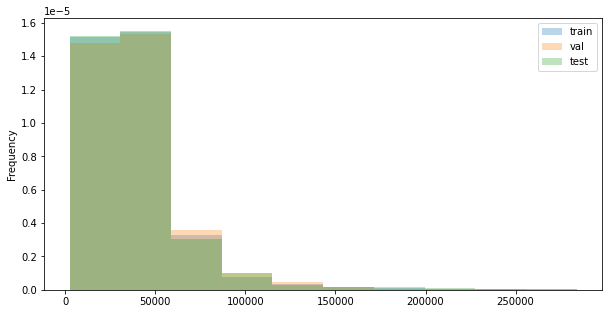

In [440]:
temp = pd.concat([y_train, y_val, y_test_ini],axis=1)
temp.columns = ['train', 'val', 'test']
temp.plot(kind='hist', density=True, alpha=0.3);
y_train.shape, y_val.shape, y_test.shape

In [456]:
def features_scaler(features, X, X_test):
  scaler = StandardScaler()
  X_scaler, X_test_scaler = X.copy(), X_test.copy()
  X_scaler[features_num] = scaler.fit_transform(X[features_num])
  X_test_scaler[features_num] = scaler.transform(X_test[features_num])

  return X_scaler, X_test_scaler


def features_log(features, X, X_test):
  X_log, X_test_log = X.copy(), X_test.copy()
  X_log[features] = np.log1p(X[features])
  X_test_log[features] = np.log1p(X_test[features])
  return X_log, X_test_log


def features_ohe(features, X, X_test):
  train_size = X.shape[0]
  df = pd.concat([X, X_test])
  df = pd.concat([df.drop(features, axis=1), 
                  pd.get_dummies(df[features].astype('object'), 
                                 drop_first=True)],#dummy_na=True
                  axis=1)
  return df.iloc[:train_size], df.iloc[train_size:]


def features_le(features, X, X_test):
  train_size = X.shape[0]
  df = pd.concat([X, X_test])
  for f in features:
    df[f] = df[f].astype('category').cat.codes
  
  return df.iloc[:train_size], df.iloc[train_size:]

def employ_ip_to_rukovoditel(X, X_test):
  X.Employment = X.Employment.astype('object')
  X.loc[X.Employment=='Индивидуальный предприниматель', 'Employment'] = 'Руководитель высшего звена'
  X_test.Employment = X_test.Employment.astype('object')
  X_test.loc[X_test.Employment=='Индивидуальный предприниматель', 'Employment'] = 'Руководитель высшего звена'


def move_na_train_to_test(features, X, y, X_test, y_test):
  X_test = pd.concat([X_test, X[X[features].isna().any(axis=1)]])
  y_test = pd.concat([y_test, y[X[features].isna().any(axis=1)]])
  y = y[X[features].notna().all(axis=1)]
  X = X[X[features].notna().all(axis=1)]
  return X, y, X_test, y_test


In [442]:
display(features_ohe(['Residence'], X_ini, X_test_ini)[0])

,ProductName,CreditSum,TypeOfWork,Employment,SignIP,sex,EducationStatus,otrasl_rabotodatelya,kolichestvo_rabotnikov_v_organizacii,OrgStanding_N,kolichestvo_detej_mladshe_18,LivingRegionName,IncomeDocumentKind,HaveSalaryCard,IsBankWorker,harakteristika_tekutschego_trudoustrojstva,RequestDate_month,RequestDate_season,RequestDate_is_month_start,RequestDate_is_month_end,RequestDate_dayofweek,RequestDate_is_weekend,RequestDate_quarter,in_region,age_cat,Residence_город,Residence_село
5197,Кредит на потребительские нужды,600000.00,по найму,Главный Специалист\Руководитель среднего звена,0,Мужской,Высшее образование,"Нефть, нефтепереработка, газ",101-500,23.000000,1,Татарстан,2-НДФЛ,нет,нет,"Постоянная, полная занятость",8,3,False,False,1,False,3,1,3,0,0
5787,Кредит на потребительские нужды,226632.00,по найму,Эксперт\Старший или Ведущий Специалист,0,Женский,Высшее образование,Прочее,более 500,13.000000,1,Татарстан,Выписка по счету,да,нет,"Постоянная, полная занятость",5,2,False,False,2,False,2,0,2,1,0
8139,Кредит на потребительские нужды,500000.00,Индивидуальный предприниматель,Индивидуальный предприниматель,ИП,Мужской,Высшее образование,Охранные предприятия,21-100,12.000000,2,Алтайский край,2-НДФЛ,да,нет,"Постоянная, полная занятость",8,3,False,False,3,False,3,0,2,0,0
1514,Кредит на потребительские нужды,564132.00,na,Сотрудник \ Рабочий \ Ассистент,0,Мужской,Высшее образование,"Нефть, нефтепереработка, газ",более 500,5.000000,1,Татарстан,2-НДФЛ,нет,нет,"Постоянная, полная занятость",9,4,False,False,0,False,3,1,1,1,0
7313,Кредит на потребительские нужды,608400.00,na,Сотрудник \ Рабочий \ Ассистент,0,Женский,Среднее специальное образование,Государственная служба,101-500,6.000000,0,Татарстан,Выписка по счету,да,нет,"Постоянная, полная занятость",12,1,False,False,2,False,4,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,Кредит на потребительские нужды,168750.00,na,Сотрудник \ Рабочий \ Ассистент,0,Женский,Среднее образование,Общественное питание,до 20,10.666666,0,Ульяновская обл.,Справка по форме Банка от работодателя,нет,нет,"Постоянная, полная занятость",7,3,False,False,0,False,3,0,3,1,0
3655,Кредит на потребительские нужды,325725.00,по найму,Главный Специалист\Руководитель среднего звена,0,Женский,Высшее образование,Образование,21-100,12.000000,1,Татарстан,Выписка по счету,да,нет,"Постоянная, полная занятость",5,2,False,False,2,False,2,1,2,1,0
1661,Кредитная карта,0.00,na,Эксперт\Старший или Ведущий Специалист,0,Женский,Незаконченное высшее образование,Финансовые институты,более 500,4.250000,0,Самарская обл.,Выписка по счету,нет,да,"Постоянная, полная занятость",10,4,False,False,3,False,4,0,2,1,0
2139,Кредитная карта,100000.00,na,Сотрудник \ Рабочий \ Ассистент,0,Женский,Незаконченное высшее образование,Прочее,21-100,0.750000,0,Москва и Московская обл.,Справка по форме Банка от работодателя,нет,нет,"Постоянная, полная занятость",11,4,False,False,1,False,4,0,0,1,0


In [393]:
X[X_ini.Residence=='na'][[f for f in X.columns if 'Residence' in f]]

,Residence_город,Residence_село
5197,0,0
8139,0,0
3365,0,0
5045,0,0
4942,0,0
...,...,...
6897,0,0
5200,0,0
8190,0,0
3426,0,0


In [450]:
X_ini[['CreditSum']].isna().any(axis=1).sum()

5

In [459]:
%%time
params = {'booster': 'gblinear',
          'objective': 'reg:squarederror',
          'eval_metric': 'rmse',
          'seed': 2020,
          'updater' : 'coord_descent',
          'feature_selector': 'greedy',  
          # 'top_k': 10,
          'alpha': 1, 
          'lambda': 0,
          # 'eta': 0.1
          }
X, X_test = X_ini.copy(), X_test_ini.copy()
y, y_test = y_ini.copy(), y_test_ini.copy()
# features = ['CreditSum', 'OrgStanding_N'] # org - dosnt change score, credite - worse
# X, X_test = features_log(features, X, X_test)

X, y, X_test, y_test = move_na_train_to_test(['CreditSum'], X,y, X_test, y_test)

# X.CreditSum.fillna(0, inplace=True)
# X_test.CreditSum.fillna(0, inplace=True)


X, X_test = features_scaler(features_num, X, X_test)

employ_ip_to_rukovoditel(X, X_test)
# X_test = pd.concat([X_test, X[X.harakteristika_tekutschego_trudoustrojstva.isna()]])
# X = X[X.harakteristika_tekutschego_trudoustrojstva.notna()]

# X.loc[X.Residence == 'na', 'Residence'] = 'село'
# X_test.loc[X_test.Residence == 'na', 'Residence'] = 'село'

to_ohe = df[features_cat + features_time].columns[df[features_cat + features_time].nunique() <20]
X, X_test = features_ohe(to_ohe, X, X_test)

to_le = [f for f in features_cat if f not in to_ohe]
X, X_test = features_le(to_le, X, X_test)





dtest = xgb.DMatrix(X_test, y_test)
dtrain = xgb.DMatrix(X, y)

num_boost = 1000

xgb.cv(params, dtrain, num_boost_round=num_boost, folds=cv5, metrics='rmse', 
       early_stopping_rounds=10, verbose_eval=1, as_pandas=True)

[0]	train-rmse:21855.7+288.746	test-rmse:22257.4+1338.31
[1]	train-rmse:21373.4+302.849	test-rmse:21824.5+1302.15
[2]	train-rmse:21192.6+313.681	test-rmse:21659+1293.76
[3]	train-rmse:21094.9+316.927	test-rmse:21577.6+1280.2
[4]	train-rmse:21031.3+318.114	test-rmse:21535+1275.29
[5]	train-rmse:20991.3+318.693	test-rmse:21505.4+1266.83
[6]	train-rmse:20967.7+318.214	test-rmse:21486.9+1262.27
[7]	train-rmse:20952.4+316.478	test-rmse:21481+1261.78
[8]	train-rmse:20943.6+315.52	test-rmse:21477.9+1258.52
[9]	train-rmse:20938.3+315.139	test-rmse:21474.5+1257.79
[10]	train-rmse:20934.8+314.513	test-rmse:21474.2+1256.72
[11]	train-rmse:20932.3+314.08	test-rmse:21472.6+1256.07
[12]	train-rmse:20930.3+313.734	test-rmse:21471.2+1255.94
[13]	train-rmse:20928.4+313.314	test-rmse:21470.3+1255.88
[14]	train-rmse:20926.6+313.035	test-rmse:21469.4+1254.77
[15]	train-rmse:20925.1+312.739	test-rmse:21469.6+1255.31
[16]	train-rmse:20923.7+312.486	test-rmse:21469+1255.27
[17]	train-rmse:20922.6+312.363	tes

22309.436567252975


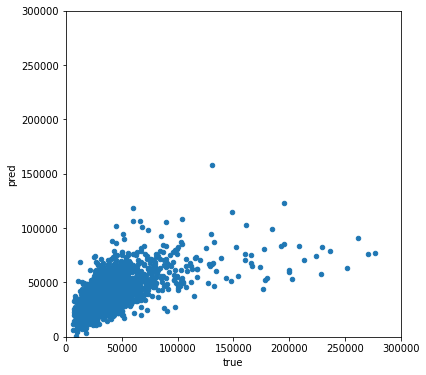

In [460]:
num_boost = 73
model = xgb.train(params, dtrain, num_boost)
pred = model.predict(dtest)

print(np.sqrt(mean_squared_error(y_test, pred)))
pd.DataFrame(np.vstack([y_test.values,pred]).T, columns=['true', 'pred']) \
    .plot(x='true', y='pred', kind='scatter', xlim=(-1,300000), ylim=(-1,300000),
          figsize=(6,6));

In [417]:
weight = model.get_dump(with_stats=False, dump_format='json')
import json

weight = np.array(json.loads(weight[0])['weight'])
features_imp = X.columns[weight.astype('bool')]
features_imp.shape, X.shape[1], features_imp 

((60,), 70, Index(['CreditSum', 'OrgStanding_N', 'in_region',
        'ProductName_Кредитная карта',
        'TypeOfWork_Агент на комиссионом договоре',
        'TypeOfWork_Индивидуальный предприниматель', 'TypeOfWork_по найму',
        'Employment_Руководитель высшего звена',
        'Employment_Сотрудник \ Рабочий \ Ассистент',
        'Employment_Эксперт\Старший или Ведущий Специалист',
        'Employment_нет данных', 'sex_Мужской',
        'EducationStatus_Высшее образование',
        'EducationStatus_Незаконченное высшее образование',
        'EducationStatus_Незаконченное среднее образование',
        'EducationStatus_Несколько высших образований',
        'EducationStatus_Среднее образование',
        'EducationStatus_Среднее специальное образование',
        'kolichestvo_rabotnikov_v_organizacii_21-100',
        'kolichestvo_rabotnikov_v_organizacii_более 500',
        'kolichestvo_rabotnikov_v_organizacii_до 20',
        'kolichestvo_detej_mladshe_18_1', 'kolichestvo_detej_ml

In [409]:
from lightgbm import LGBMRegressor, cv
import lightgbm as lgb
import matplotlib.gridspec as gridspec

20976.474007722627


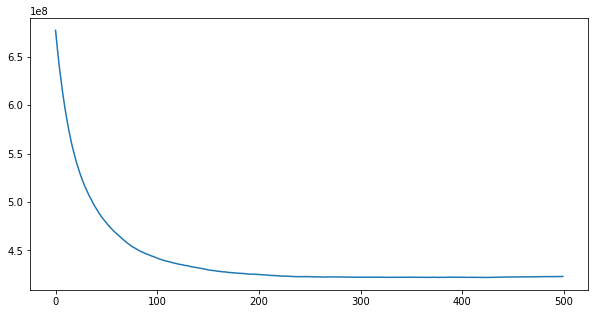

In [418]:
# features_null_imp_cat = [f for f in features_cat if f in features_null_imp_gain]
dtrain = lgb.Dataset(X, y)

params = {'learning_rate': 0.03,
          'num_leaves': 17,
          'min_child_samples': 15,
        # 'subsample': 0.623,
        # 'colsample_bytree': 0.2,
        # 'max_depth': 3,
        # 'seed': seed,
        # 'bagging_freq': 1,
        
          'objective': 'mean_squared_error',
          'n_jobs': -1,
          # 'is_unbalance': False
          }

res = cv(params, dtrain, num_boost_round=500, folds=cv5)
print(np.sqrt(np.mean(res['l2-mean'])))
pd.Series(res['l2-mean']).plot();

21470.331497524145


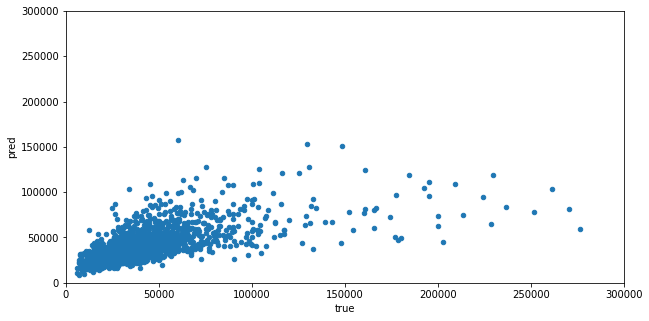

In [419]:
dtest = lgb.Dataset(X_test, y_test)
clf = lgb.train(params, dtrain, num_boost_round=500)
pred = clf.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, pred)))
pd.DataFrame(np.vstack([y_test.values,pred]).T, columns=['true', 'pred']) \
    .plot(x='true', y='pred', kind='scatter', xlim=(-1,300000), ylim=(-1, 300000));

21321.75580640313


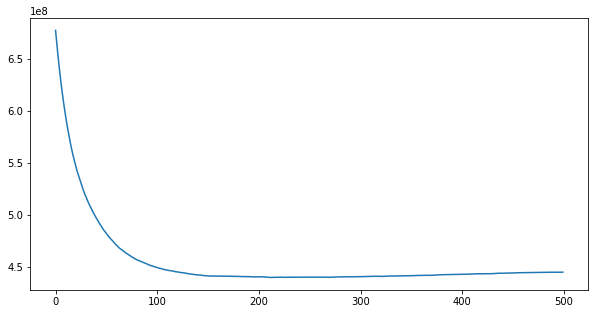

In [420]:
dtrain = lgb.Dataset(X[features_imp], y)
res = cv(params, dtrain, num_boost_round=500, folds=cv5,
   )
print(np.sqrt(np.mean(res['l2-mean'])))
pd.Series(res['l2-mean']).plot();

21877.20380396677


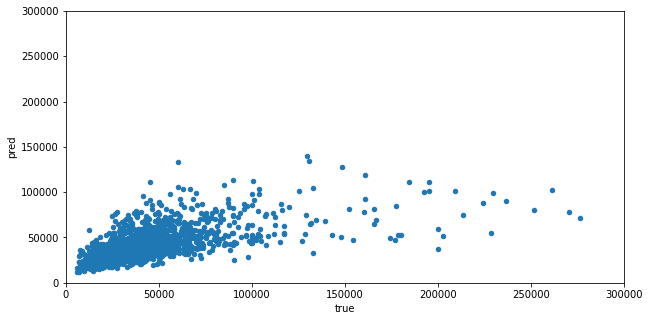

In [421]:
dtest = lgb.Dataset(X_test[features_imp], y_test)
clf = lgb.train(params, dtrain, num_boost_round=300)
pred = clf.predict(X_test[features_imp])

print(np.sqrt(mean_squared_error(y_test, pred)))
pd.DataFrame(np.vstack([y_test.values,pred]).T, columns=['true', 'pred']) \
    .plot(x='true', y='pred', kind='scatter', xlim=(-1,300000), ylim=(-1, 300000));